In [ ]:
import pandas as pd
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import torch
import re

# Load the Hugging Face pipeline for Zero-Shot classification
zero_shot_classifier = pipeline("zero-shot-classification")

# Function to get Hugging Face response for Zero-Shot classification
def get_huggingface_response(prompt, model="facebook/bart-large-mnli", temperature=0.7):
    result = zero_shot_classifier(prompt, candidate_labels=["correct", "incorrect", "complete", "incomplete", "comprehensive", "incomplete"])
    return result['scores'][0]  # Return the score for the most likely label

# Function to compute correctness score using Hugging Face (Zero-Shot and Few-Shot)
def compute_correctness_score(description, disease_term, model="facebook/bart-large-mnli"):
    # Zero-shot Prompt: Hugging Face should evaluate how similar the disease term is to the description
    zero_shot_prompt = f"Evaluate the correctness of the disease description in relation to the disease term. The description: '{description}' and the disease term: '{disease_term}'. Rate the correctness on a scale from 0 to 1."

    correctness_score_zero_shot = get_huggingface_response(zero_shot_prompt, model)
    return correctness_score_zero_shot


# Function to compute completeness score using Hugging Face (Zero-Shot and Few-Shot)
def compute_completeness_score(description, model="facebook/bart-large-mnli"):
    # Zero-shot Prompt: Hugging Face should evaluate if the description covers all aspects of the disease
    zero_shot_prompt = f"Is the following disease description complete? Does it include key symptoms, diagnostic information, and relevant details about the disease? Describe any missing aspects. The description: '{description}'"

    completeness_score_zero_shot = get_huggingface_response(zero_shot_prompt, model)
    return completeness_score_zero_shot


# Function to compute comprehensiveness score using Hugging Face (Zero-Shot and Few-Shot)
def compute_comprehensiveness_score(description, model="facebook/bart-large-mnli"):
    # Zero-shot Prompt: Hugging Face should evaluate the comprehensiveness of the description
    zero_shot_prompt = f"Is the following disease description comprehensive? Does it include symptoms, diagnostic tests, treatments, and all relevant details? Rate the comprehensiveness on a scale from 0 to 1. The description: '{description}'"

    comprehensiveness_score_zero_shot = get_huggingface_response(zero_shot_prompt, model)
    return comprehensiveness_score_zero_shot


# Few-shot Prompting Example for Correctness, Completeness, and Comprehensiveness
def few_shot_prompt(prompt, model="gpt2"):
    # Example 1: Correctness
    example_1 = "Description: 'A condition characterized by joint pain and stiffness. Often causes inflammation.' Disease Term: 'Arthritis'. Correctness: 0.8"
    example_2 = "Description: 'A disorder affecting the nervous system with symptoms of paralysis and muscle weakness.' Disease Term: 'Multiple Sclerosis'. Correctness: 0.9"

    # Example 2: Completeness
    example_3 = "Description: 'A disease caused by the flu virus, characterized by fever, chills, sore throat, and fatigue.' Completeness: 0.8"
    example_4 = "Description: 'A chronic condition involving high blood sugar levels and insulin resistance.' Completeness: 0.9"

    # Example 3: Comprehensiveness
    example_5 = "Description: 'A condition that involves an autoimmune response that attacks the joints.' Comprehensiveness: 0.7"
    example_6 = "Description: 'A mental health condition characterized by persistent sadness, feelings of hopelessness, and a lack of interest in daily activities.' Comprehensiveness: 0.85"

    # Combine the examples and prompt
    few_shot_examples = "\n".join([example_1, example_2, example_3, example_4, example_5, example_6])

    prompt_with_few_shot = f"{few_shot_examples}\n\n{prompt}"

    # Use the GPT-2 model from Hugging Face for Few-Shot Prompting
    tokenizer = AutoTokenizer.from_pretrained(model)
    model = AutoModelForCausalLM.from_pretrained(model)

    inputs = tokenizer(prompt_with_few_shot, return_tensors="pt")
    outputs = model.generate(**inputs, max_length=500, num_return_sequences=1, temperature=0.7)

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract the numerical score from the response using regex (e.g., for correctness)
    match = re.search(r"(\d\.\d+)", response)
    if match:
        return float(match.group(1))  # Return the numerical score
    else:
        return 0.0  # Default to 0.0 if no match is found


# Read the CSV file using pandas (replace 'your_file.csv' with the actual file path)
csv_file_path = 'MedRed_AMT_labels.csv'  # Replace this with your actual CSV file path
df = pd.read_csv(csv_file_path)

# Initialize score accumulators for both Zero-Shot and Few-Shot approaches
zero_shot_correctness_scores = []
zero_shot_completeness_scores = []
zero_shot_comprehensiveness_scores = []

few_shot_correctness_scores = []
few_shot_completeness_scores = []
few_shot_comprehensiveness_scores = []

# Evaluate the first few rows of the CSV file
for i in range(7):
    description = df.iloc[i]['post']  # Adjust the column name accordingly
    disease_term = df.iloc[i]['subreddit']  # Adjust the column name accordingly

    # Compute the scores using Zero-Shot approach
    correctness_score_zero_shot = compute_correctness_score(description, disease_term)
    completeness_score_zero_shot = compute_completeness_score(description)
    comprehensiveness_score_zero_shot = compute_comprehensiveness_score(description)

    zero_shot_correctness_scores.append(correctness_score_zero_shot)
    zero_shot_completeness_scores.append(completeness_score_zero_shot)
    zero_shot_comprehensiveness_scores.append(comprehensiveness_score_zero_shot)

    # Compute the scores using Few-Shot approach
    few_shot_correctness_prompt = f"Evaluate the correctness of the disease description: '{description}' with the disease term: '{disease_term}'. Rate the correctness from 0 to 1."
    few_shot_completeness_prompt = f"Is the following disease description complete? Rate the completeness from 0 to 1. The description: '{description}'"
    few_shot_comprehensiveness_prompt = f"Evaluate if the description includes symptoms, diagnostic tests, and treatments. Rate the comprehensiveness from 0 to 1. The description: '{description}'"

    correctness_score_few_shot = few_shot_prompt(few_shot_correctness_prompt)
    completeness_score_few_shot = few_shot_prompt(few_shot_completeness_prompt)
    comprehensiveness_score_few_shot = few_shot_prompt(few_shot_comprehensiveness_prompt)

    few_shot_correctness_scores.append(correctness_score_few_shot)
    few_shot_completeness_scores.append(completeness_score_few_shot)
    few_shot_comprehensiveness_scores.append(comprehensiveness_score_few_shot)

# Calculate the average scores for Zero-Shot and Few-Shot approaches
avg_zero_shot_correctness = sum(zero_shot_correctness_scores) / len(zero_shot_correctness_scores)
avg_zero_shot_completeness = sum(zero_shot_completeness_scores) / len(zero_shot_completeness_scores)
avg_zero_shot_comprehensiveness = sum(zero_shot_comprehensiveness_scores) / len(zero_shot_comprehensiveness_scores)

avg_few_shot_correctness = sum(few_shot_correctness_scores) / len(few_shot_correctness_scores)
avg_few_shot_completeness = sum(few_shot_completeness_scores) / len(few_shot_completeness_scores)
avg_few_shot_comprehensiveness = sum(few_shot_comprehensiveness_scores) / len(few_shot_comprehensiveness_scores)

# Print out the average scores for both Zero-Shot and Few-Shot approaches
print(f"Average Zero-Shot Correctness Score: {avg_zero_shot_correctness}")
print(f"Average Zero-Shot Completeness Score: {avg_zero_shot_completeness}")
print(f"Average Zero-Shot Comprehensiveness Score: {avg_zero_shot_comprehensiveness}")
print(f"Average Few-Shot Correctness Score: {avg_few_shot_correctness}")
print(f"Average Few-Shot Completeness Score: {avg_few_shot_completeness}")
print(f"Average Few-Shot Comprehensiveness Score: {avg_few_shot_comprehensiveness}")


No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_

Average Zero-Shot Correctness Score: 0.30413214010851725
Average Zero-Shot Completeness Score: 0.4247873084885733
Average Zero-Shot Comprehensiveness Score: 0.30719225321497234
Average Few-Shot Correctness Score: 0.7999999999999999
Average Few-Shot Completeness Score: 0.7999999999999999
Average Few-Shot Comprehensiveness Score: 0.7999999999999999


In [3]:
import pandas as pd
from tqdm import tqdm

# Function to extract unique pairs of subreddit and post
def get_unique_pairs(df):
    unique_pairs = set()  # Store unique pairs in a set to avoid duplicates
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing Entries"):
        pair = (row['subreddit'], row['post'])
        unique_pairs.add(pair)
    return unique_pairs

# Function to calculate uniqueness and duplication scores for a dataset
def calculate_scores(df):
    unique_pairs = get_unique_pairs(df)
    total_entries = len(df)
    unique_pairs_count = len(unique_pairs)

    # Calculate scores
    uniqueness_score = unique_pairs_count / total_entries
    duplication_score = 1 - uniqueness_score  # Duplication score is the complement of uniqueness

    return uniqueness_score, duplication_score

# Load the dataset
dataset_path = 'MedRed_AMT_labels.csv'
df = pd.read_csv(dataset_path)

# Calculate and print the scores for the dataset
uniqueness_score, duplication_score = calculate_scores(df)
print(f"Uniqueness Score: {uniqueness_score:.4f}")
print(f"Duplication Score: {duplication_score:.4f}")


Processing Entries: 100%|██████████| 1976/1976 [00:00<00:00, 9740.36it/s] 

Uniqueness Score: 0.9995
Duplication Score: 0.0005


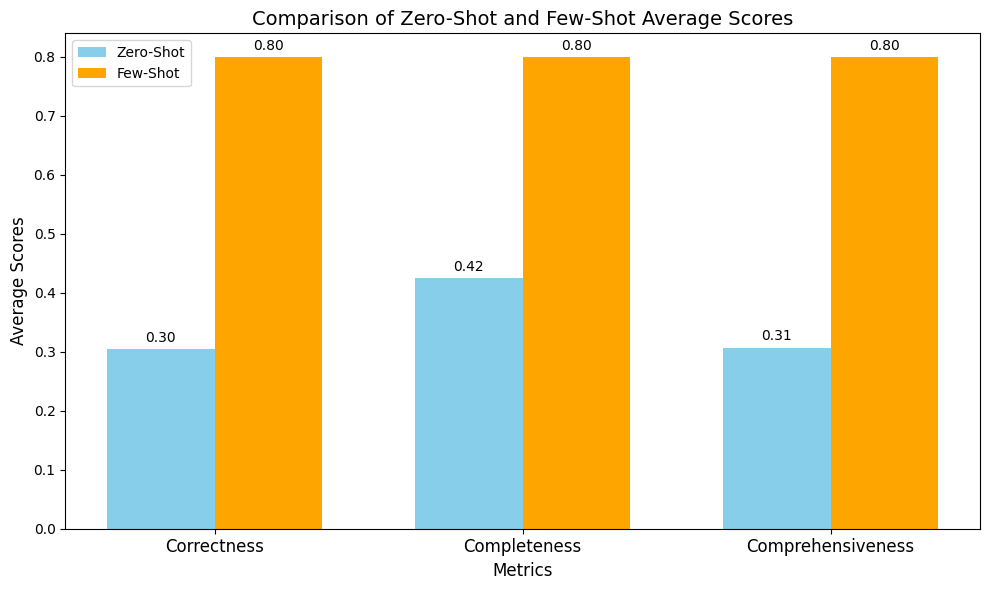

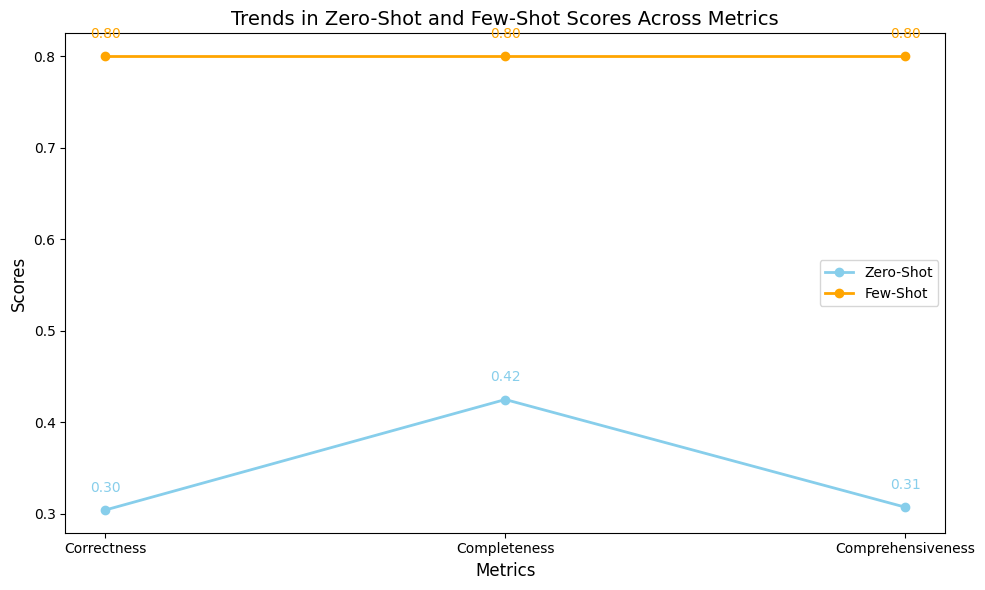

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the visualizations
metrics = ["Correctness", "Completeness", "Comprehensiveness"]
zero_shot_scores = [0.3041, 0.4248, 0.3072]
few_shot_scores = [0.8, 0.8, 0.8]

# Bar Plot: Average Scores
x = np.arange(len(metrics))  # Label locations
width = 0.35  # Width of bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, zero_shot_scores, width, label="Zero-Shot", color="skyblue")
bars2 = ax.bar(x + width/2, few_shot_scores, width, label="Few-Shot", color="orange")

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel("Metrics", fontsize=12)
ax.set_ylabel("Average Scores", fontsize=12)
ax.set_title("Comparison of Zero-Shot and Few-Shot Average Scores", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.legend()

# Adding score labels on the bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Line Chart: Trend of Scores Across Metrics
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(metrics, zero_shot_scores, marker='o', label="Zero-Shot", color="skyblue", linewidth=2)
ax.plot(metrics, few_shot_scores, marker='o', label="Few-Shot", color="orange", linewidth=2)

# Add labels, title, and legend
ax.set_xlabel("Metrics", fontsize=12)
ax.set_ylabel("Scores", fontsize=12)
ax.set_title("Trends in Zero-Shot and Few-Shot Scores Across Metrics", fontsize=14)
ax.legend()

# Adding score points
for i, score in enumerate(zero_shot_scores):
    ax.text(i, score + 0.02, f'{score:.2f}', ha='center', fontsize=10, color="skyblue")
for i, score in enumerate(few_shot_scores):
    ax.text(i, score + 0.02, f'{score:.2f}', ha='center', fontsize=10, color="orange")

plt.tight_layout()
plt.show()
